# **Importing important packages**

In [1]:
%tensorflow_version 1.X

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.X`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
pip install 'h5py<3.0.0'

In [2]:
import tensorflow
print(tensorflow.__version__)
print(tensorflow.keras.__version__)

1.15.2
2.2.4-tf


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import keras
import numpy as np
import os
from keras import backend as K
import cv2
from keras.preprocessing.image import ImageDataGenerator
import pickle
from keras.callbacks import ModelCheckpoint
from skimage import img_as_ubyte

from keras.models import *
from keras.layers import *
from keras.optimizers import *

seed = 5421
np.random.seed(seed)

startDir = '/content/drive/My Drive/Colab Notebooks/swri_research/data/'
weights_dir = startDir

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Creating the model**

In [4]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [5]:
# #####Model with BatchNorm#####
# #(x,y,ch)
# #(90,90,225)
model = Sequential() 
model.add(Conv2D(32, (3, 3), input_shape = (90,90,225),padding='same')) 
model.add(Activation('swish'))
model.add(BatchNormalization()) 
model.add(Conv2D(32, (3, 3),padding='same')) 
model.add(Activation('swish')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size =(2, 2), strides=(2,2))) 

#(45,45,32)
model.add(Conv2D(64, (3, 3))) 
model.add(Activation('swish'))
model.add(BatchNormalization()) 
model.add(Conv2D(64, (3, 3))) 
model.add(Activation('swish')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size =(2, 2), strides=(2,2))) 

#(20,20,64)
model.add(Conv2D(128, (3, 3))) 
model.add(Activation('swish'))
model.add(BatchNormalization()) 
model.add(Conv2D(128, (3, 3))) 
model.add(Activation('swish')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size =(2, 2), strides=(2,2))) 



#(8,8,128)
model.add(Conv2D(256, (3, 3))) 
model.add(Activation('swish'))
model.add(BatchNormalization()) 
model.add(Conv2D(256, (3, 3))) 
model.add(Activation('swish')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size =(2, 2), strides=(2,2))) 


#(2,2,256)
model.add(Conv2D(512, (2, 2))) 
model.add(Activation('swish'))


#(1,1,512)  
model.add(Flatten()) 
model.add(Dense(512)) 
model.add(Activation('swish')) 
model.add(Dropout(0.5)) 
model.add(Dense(512)) 
model.add(Activation('swish')) 
model.add(Dropout(0.5))
model.add(Dense(1)) 
model.add(Activation('sigmoid'))

In [ ]:
sgd = SGD(lr=0.0001, momentum=0.9, nesterov=True)
model.compile(loss ='binary_crossentropy',  optimizer = sgd, metrics =['accuracy']) 

# **Using trained model-ensemble on a 'bipolar emergence' video to detect frame of emergence**

In [7]:
blocks = ['12','34','56','78','9X']
version = ['v3','v4']

from scipy.interpolate import interp1d
from skimage.measure import label, regionprops
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import csv
import matplotlib.pyplot as plt
import matplotlib.colors

comments = []
paths = []

with open('/content/drive/My Drive/Colab Notebooks/swri_research/data/BARD_v2/'+'BARD_v2_file_test_path_label_f.csv', 'r') as f:
  reader = csv.reader(f)
  for row in reader:
    comments.append(row[2])
    paths.append(row[0])

f_no = 78 
idx = comments.index('bipolar emergence '+str(f_no))
print(paths[idx])
thres = 0.95
image_loc = paths[idx]
path = '/content/drive/My Drive/Colab Notebooks/swri_research/data'+image_loc
y = fits.open(path)
yy = fits.open(path[:-5]+'.dt.fits')
imgs = np.transpose(y[0].data)
imgs=np.clip(imgs,-1000,1000)
imgs=0.5*(1+imgs/1000)
frame=yy[0].data/5760
frame=frame.astype('int')
lst = frame.tolist()
miss = []
mn=int(np.min(frame))
mx=int(np.max(frame)+1)
for i in range(mn,mx):
  if i not in lst:
    miss.append(i)

X = np.zeros((1,90,90,225),dtype=float)
for i in range(len(frame)):
  X[0,:,:,frame[i]] = imgs[:,:,i]
for i in range(mx,225):
  X[0,:,:,i] = imgs[:,:,len(frame)-1]
ind_q=frame
ind_i=np.arange(mx)
for i in range(90):
  for j in range(90):
    f_q = X[0,i,j,ind_q]
    f = interp1d(ind_q, f_q, kind = 'linear')
    X[0,i,j,ind_i]=f(ind_i)

im = (X==0)
for j in range(225):
  label_image = label(im[0,:,:,j])
  mn=np.min(label_image)
  mx=np.max(label_image)+1
  for r in range(mn,mx):
    bw=(label_image == r)*im[0,:,:,j]
    if bw[0,0]==1 or bw[0,89]==1 or bw[89,0]==1 or bw[89,89]==1:
      X[0,:,:,j]=0.5*bw+X[0,:,:,j]


data_lb=X.copy()
lower_bound=30

for j in range(lower_bound):
  data_lb[0,:,:,j]=data_lb[0,:,:,lower_bound]


data1 = data_lb.copy()

pred_val = np.zeros((10,225))

for i in range(225):
  n = 0
  k = 0
  data1[0,:,:,:(i+1)]=data_lb[0,:,:,:(i+1)].copy()
  for j in range(i+1,225):
    data1[0,:,:,j]=data_lb[0,:,:,i]  
  for v in version:
      for b in blocks:
        st = '/content/drive/My Drive/Colab Notebooks/swri_research/code/flux_emrg_weights_newData_vgg_'+ b +'_pass_f_'+ v +'.h5'
        model.load_weights(st)
        pred=model.predict(data1)
        pred_val[k,i] = pred[0][0]
        k = k+1

/BARD_v2/Emergence/Test/BARD0310_19981206.fits


ensemble frame prediction: [94 90 89 91 93 92 93 95 98 99]


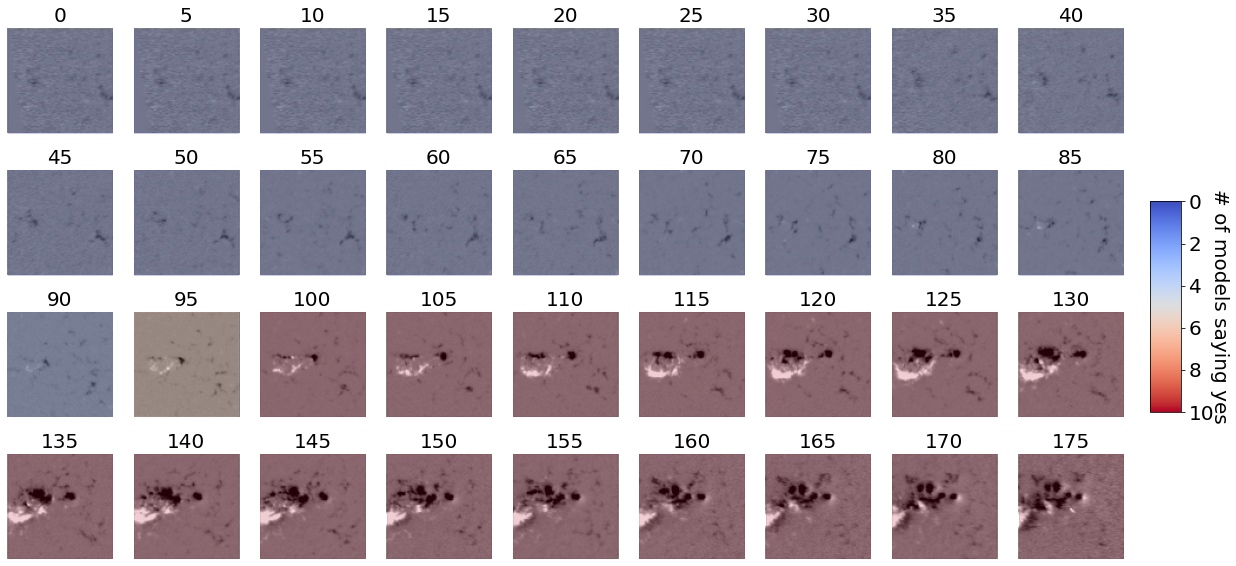

In [11]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
cmap = plt.cm.coolwarm
norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
frame_seq = np.zeros(10,dtype='int')
for n in range(10):
  pred_val_g = np.gradient(pred_val[n,:])
  frame_seq[n] = np.where(pred_val_g == np.max(pred_val_g))[0]
print('ensemble frame prediction: '+ str(frame_seq))
fig, axs = plt.subplots(4,9, figsize=(20, 10))
axs = axs.ravel()
for n in range(36):
  axs[n].imshow(np.flip(np.transpose(data1[0,:,:,5*n]),0),cmap='gray',vmin=0,vmax=1);axs[n].axis("off");axs[n].fill_between([0,89],[0,0],[89,89], alpha=0.2,color=cmap(norm(np.sum(frame_seq<5*n))));axs[n].set_title(str(5*n),fontsize=20)
  if n == 26:
    inset_axes_c = inset_axes(axs[n],bbox_to_anchor=(1.3, 0, 0.3, 2),
                   bbox_transform=axs[n].transAxes,
                    width="100%", # width = 30% of parent_bbox
                    height="100%", # height : 1 inch
                    loc=4)
    cbar = plt.colorbar(sm,cax=inset_axes_c)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.invert_yaxis() 
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('# of models saying yes', rotation=270,fontsize=20)